In [27]:
import os
import googleapiclient.discovery
import googleapiclient.errors
from google.oauth2 import service_account
from typing import Literal, Union
import configparser
import requests
import enum
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO

In [3]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
config = configparser.ConfigParser()
config.read("config/config.ini")
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
api_service_name = "youtube"
api_version = "v3"

In [4]:
class ThumbnailSize(enum.Enum):
    MAXRES = "maxres"
    HIGH = "high"
    MEDIUM = "medium"
    DEFAULT = "default"
    STANDARD = "standard"

    def __str__(self):
        return self.name

In [ ]:
class YoutubeAPI:
    def __init__(self):
        self.config_file = config["API"]["CONFIG_FILE"]
        credentials = service_account.Credentials.from_service_account_file(
            self.config_file, scopes=scopes
        )
        self.youtube = googleapiclient.discovery.build(
            api_service_name, api_version, credentials=credentials
        )

    def get_channel(self, channel_id):
        request = self.youtube.channels().list(
            part="snippet,contentDetails,statistics", id=channel_id
        )
        response = request.execute()
        return response

    def get_playlist(self, playlist_id):
        request = self.youtube.playlistItems().list(
            part="snippet,contentDetails", playlistId=playlist_id
        )
        response = request.execute()
        return response

    def get_video(self, video_id):
        request = self.youtube.videos().list(part="snippet,contentDetails,statistics", id=video_id)
        response = request.execute()
        return response

    def get_thumbnail(
        self,
        video,
        resolution: Literal[
            ThumbnailSize.DEFAULT,
            ThumbnailSize.STANDARD,
            ThumbnailSize.MEDIUM,
            ThumbnailSize.HIGH,
            ThumbnailSize.MAXRES,
        ] = ThumbnailSize.DEFAULT,
        getsize: bool = False,
    ) -> Union[str, tuple[str, tuple[int, int]]]:
        """
        Retrieves the thumbnail of a video

        Notes:
        - getsize is a boolean indicating if the size of the thumbnail should be returned

        Returns:
        - url (str) - The URL of the thumbnail
        - size (tuple) - The size of the thumbnail (width, height)
        """
        thumbnail = video["items"][0]["snippet"]["thumbnails"][resolution.value]
        size = (
            thumbnail["width"],
            thumbnail["height"],
        )
        return thumbnail["url"], size if getsize else thumbnail["url"], None

    def get_video_description(self, video):
        """
        Retrieves the description of a video
        """
        return video["items"][0]["snippet"]["description"]

    def get_video_category(self, video):
        """
        Retrieves the category of a video (e.g. Music, Entertainment, etc.)
        """
        category_id = video["items"][0]["snippet"]["categoryId"]
        request = self.youtube.videoCategories().list(part="snippet", id=category_id)
        response = request.execute()
        return response["items"][0]["snippet"]["title"]

    def get_video_stats(self, video):
        """
        Retrieves the statistics of a video:
        - viewCount (int) - The number of times the video has been viewed
        - likeCount (int) - The number of times the video has been liked
        - favoriteCount (int) - The number of times the video has been added to a user's favorites
        - commentCount (int) - The number of comments on the video
        """
        stats = video["items"][0]["statistics"]
        return stats

    def get_top_videos(self, channel, num_videos: int = 10):
        request = self.youtube.search().list(
            part="snippet",
            channelId=channel,
            maxResults=num_videos,
            order="viewCount",
            type="video",
        )
        response = request.execute()
        return response

    def get_last_channel_videos(self, channel_id, num_videos: int = 10):
        """
        Retrieves the last {num_videos} videos from a channel
        """
        request = self.youtube.search().list(
            part="snippet", channelId=channel_id, maxResults=num_videos, order="date", type="video"
        )
        response = request.execute()
        return response

    def get_channel_videos_timerange(self, channel_id, start_time: str, end_time: str):
        """
        Retrieves the videos from a channel within a time range

        Notes:
        - The time range is in the format "YYYY-MM-DDTHH:MM:SSZ" (e.g. "2021-01-01T00:00:00Z")
        """
        request = self.youtube.search().list(
            part="snippet",
            channelId=channel_id,
            publishedAfter=start_time,
            publishedBefore=end_time,
            type="video",
        )
        response = request.execute()
        return response

yt = YoutubeAPI()

In [ ]:
def show_thumbnail_from_url(url):
    response = requests.get(url)
    fig = plt.imshow(Image.open(BytesIO(response.content)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [30]:
channel_id = "UCX6OQ3DkcsbYNE6H8uQQuVA"
channel = yt.get_channel(channel_id)

In [35]:
videos_may_2024 = yt.get_channel_videos_timerange(channel_id, "2024-05-01T00:00:00Z", "2024-06-01T00:00:00Z")

In [36]:
videos_may_2024

{'kind': 'youtube#searchListResponse',
 'etag': '4g0eFCtcBPxyBeeufyCVg3phZJE',
 'nextPageToken': 'CAUQAA',
 'regionCode': 'PL',
 'pageInfo': {'totalResults': 34, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#searchResult',
   'etag': 'FEwVTfqIwV24VnMeWPD66cUS7PA',
   'id': {'kind': 'youtube#video', 'videoId': 'oA4LSZvX4iE'},
   'snippet': {'publishedAt': '2024-05-09T16:00:00Z',
    'channelId': 'UCX6OQ3DkcsbYNE6H8uQQuVA',
    'title': 'Ages 1-100 Try My Chocolate',
    'description': '',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/oA4LSZvX4iE/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/oA4LSZvX4iE/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/oA4LSZvX4iE/hqdefault.jpg',
      'width': 480,
      'height': 360}},
    'channelTitle': 'MrBeast',
    'liveBroadcastContent': 'none',
    'publishTime': '2024-05-09T16:00:00Z'}},
  {'kind': 'youtube#searchRe

In [34]:
last_video = yt.get_last_channel_videos(channel_id, 1)
last_video

{'kind': 'youtube#searchListResponse',
 'etag': 'dYRixXCU8jP0uOnE01mklaTblL8',
 'nextPageToken': 'CAEQAA',
 'regionCode': 'PL',
 'pageInfo': {'totalResults': 93403, 'resultsPerPage': 1},
 'items': [{'kind': 'youtube#searchResult',
   'etag': 'k_HgMFCDA2I9Dls153v_2iY1v8w',
   'id': {'kind': 'youtube#video', 'videoId': 'Xj0Jtjg3lHQ'},
   'snippet': {'publishedAt': '2024-11-02T16:00:00Z',
    'channelId': 'UCX6OQ3DkcsbYNE6H8uQQuVA',
    'title': '$1 vs $500,000 Experiences!',
    'description': "I didn't know some of these were possible MrBeast Lab Swarms are flying off the shelves! Grab yours now at Walmart, Target, ...",
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/Xj0Jtjg3lHQ/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/Xj0Jtjg3lHQ/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/Xj0Jtjg3lHQ/hqdefault.jpg',
      'width': 480,
      'height': 360}},
    'chann

In [2]:
top_10_videos

NameError: name 'top_10_videos' is not defined

In [43]:
top_10_videos = yt.get_top_videos(channel_id, 10)
views_top_10 = [{"title": video["items"][0]["title"], "views": yt.get_video_stats(video["items"][0]["id"]["kind"]["videoID"])["viewCount"]} for video in top_10_videos]
views_top_10

TypeError: string indices must be integers, not 'str'

In [ ]:
video_id = "Xj0Jtjg3lHQ"
video = yt.get_video(video_id)

In [102]:
thumbnail = yt.get_thumbnail(video, resolution=ThumbnailSize.MAXRES, getsize=True)
thumbnail

('https://i.ytimg.com/vi/Xj0Jtjg3lHQ/maxresdefault.jpg', (1280, 720))

In [103]:
category = yt.get_video_category(video)
category

'Entertainment'

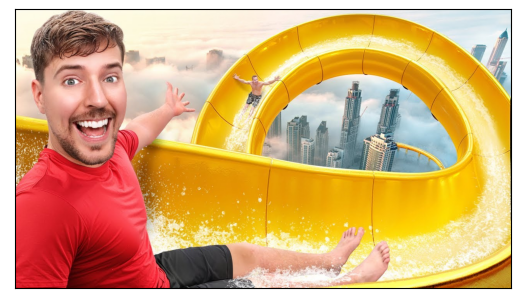

In [105]:
show_thumbnail_from_url(thumbnail[0])

In [71]:
stats = yt.get_video_stats(video)
stats

{'viewCount': '64101653',
 'likeCount': '2887577',
 'favoriteCount': '0',
 'commentCount': '37484'}